In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [301]:
import numpy as np
import pandas as pd
from math import log10
import itertools as it

In [377]:
seqs = {}
L = []
with open('./stripped') as f:
    for seq in f:
        if seq[0] != '#':
            seq_id, seq_array = seq.split()
            seq_array = [int(x) for x in seq_array.split(',') if x]

            if seq_array:
                seqs[seq_id] = seq_array


In [378]:
M = max([len(x) for x in seqs.values()])
for seq_id, seq_array in seqs.items():
    seqs[seq_id] = np.array(seq_array)

## Length of sequences logged in EOIS

In [387]:
seqlen = pd.Series(np.array([len(x) for x in seqs.values()]))

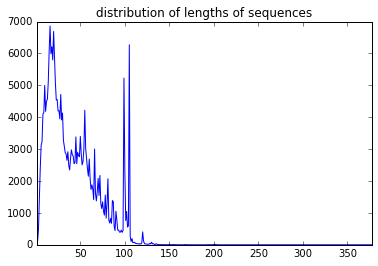

In [388]:
seqlen.value_counts().sort_index().plot(title='distribution of lengths of sequences')
plt.show()

In [389]:
print('descriptive stats on the lengths of sequences\n')
print(seqlen.describe().to_string())

descriptive stats on the lengths of sequences

count    274554.000000
mean         41.674261
std          28.053803
min           1.000000
25%          19.000000
50%          34.000000
75%          59.000000
max         377.000000


## Qualitative exploration of sequences
How many unique values? How many are monotonic? Positive? Max value?

In [426]:
def isMonotonic(seq):
    inc = all(x <= y for (x,y) in zip(seq,seq[1:]))
    dec = all(x >= y for (x,y) in zip(seq,seq[1:]))
    return (inc or dec)

def isNonNeg(seq):
    return all(x >= 0 for x in seq)

def pctUnique(seq):
    return len(set(seq))/len(seq)

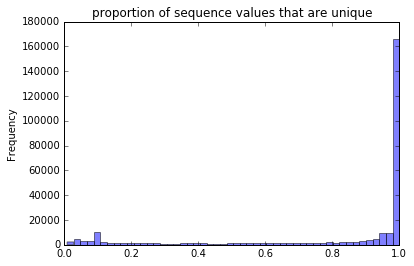

In [431]:
title = 'proportion of sequence values that are unique'
pd.Series(map(pctUnique, seqs.values())).plot(kind='hist', bins=50, alpha=0.5, title=title)
plt.show()

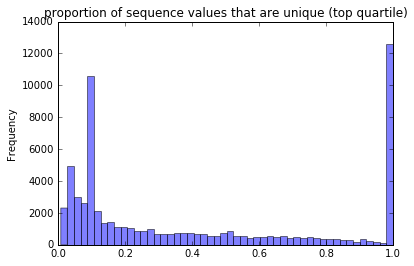

In [432]:
title = 'proportion of sequence values that are unique (top quartile)'
pd.Series(map(pctUnique, [x for x in seqs.values() if len(x) > 60])).plot(kind='hist', bins=50, alpha=0.5, title=title)
plt.show()

In [433]:
print("How many sequences are (weakly) monotonic?")
print(pd.Series(map(isMonotonic, seqs.values())).value_counts().to_string())

How many sequences are (weakly) monotonic?
True     175253
False     99301


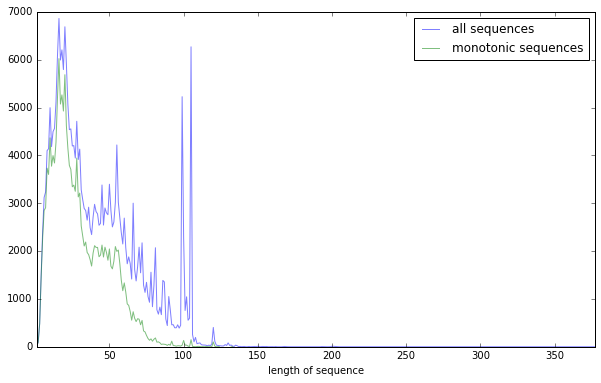

In [450]:
a = pd.Series([len(x) for x in seqs.values()]).value_counts().sort_index()
b = pd.Series([len(x) for x in seqs.values() if isMonotonic(x)]).value_counts().sort_index()
a.name, b.name = 'all sequences', 'monotonic sequences'
pd.concat([a,b], axis=1).plot(figsize=(10,6), alpha=0.5).set_xlabel('length of sequence')
plt.show()

In [434]:
print("How many sequences are positive?")
print(pd.Series(map(isNonNeg, seqs.values())).value_counts().to_string())

How many sequences are positive?
True     259920
False     14634


Max values/magnitudes (log-scaled)

In [393]:
M = pd.Series([log10(abs(max(x))) for x in seqs.values() if max(x) != 0])

In [394]:
print('statistics on the max digit found in a given sequence (log10-scaled)\n')
print(M.describe().to_string())

statistics on the max digit found in a given sequence (log10-scaled)

count    274480.000000
mean          9.949632
std          12.110155
min           0.000000
25%           2.462398
50%           5.374786
75%          14.438122
max         284.670750


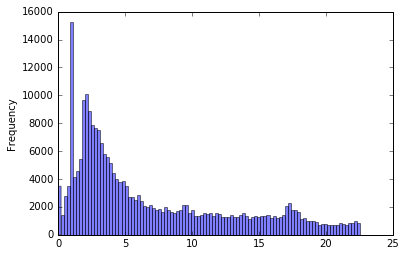

In [451]:
M[M < M.quantile(0.9)].plot(kind='hist', bins=100, alpha=0.5)
plt.show()

### What is that spike? (spoiler: decimal expansions!)

In [396]:
print("the most common max value is: %1.f" %10**M.value_counts().index[0])

the most common max value is: 9


These sequences most likely consist of decimal expansions of (various transcentendal) numbers of interest.
* as expected, the likelihood of occurence of any digit is approximately uniform.

In [397]:
decexp = [ x for x in seqs.values() if max(x) == 9 and min(x) >= 0]

In [398]:
a = (
    pd.concat([ pd.Series(x).value_counts() for x in decexp], axis=1)
     .apply(lambda x:x/x.sum())
     .T
     )

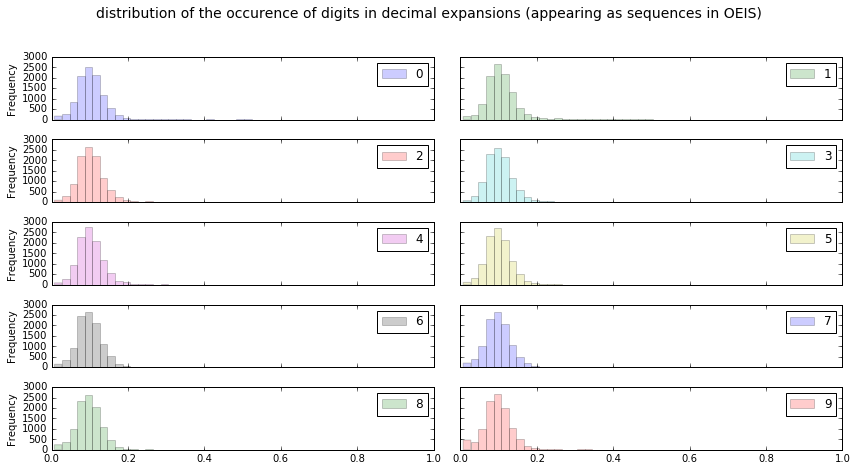

In [399]:
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(12,6))
title = 'distribution of the occurence of digits in decimal expansions (appearing as sequences in OEIS)'
fig.suptitle(title, fontsize=14, y=1.08)
a.plot(kind='hist', alpha=0.2, bins=50, subplots=True, ax=ax)
plt.tight_layout()
plt.show()

Moreover, the spike of length-100 sequences are mostly made up of the decimal expansions -- probably, because most are not computed by hand and that's a nice round number

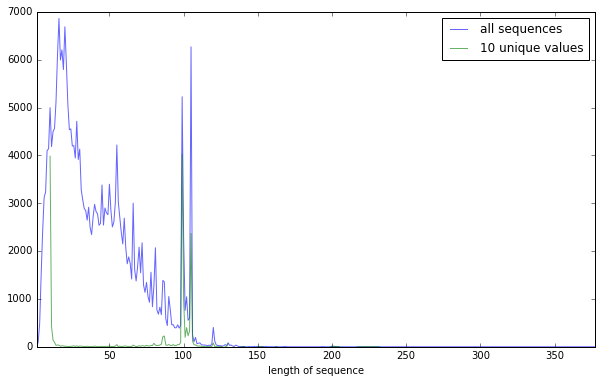

In [463]:
a = pd.Series([len(x) for x in seqs.values()]).value_counts().sort_index()
b = pd.Series([len(x) for x in seqs.values() if len(set(x)) == 10]).value_counts().sort_index()
a.name, b.name = 'all sequences', '10 unique values'
pd.concat([a,b], axis=1).plot(figsize=(10,6), alpha=0.6).set_xlabel('length of sequence')
plt.show()

## Growth of values in sequences

In [482]:
def grad(n, L):
    for _ in range(n):
        L = np.gradient(L)
    return L

In [669]:
L = []
for k,v in seqs.items():
    for i in it.count(1):
        a = pd.Series(v)
        if len(a) <= 1:
            break
        m, r = max(a), max(grad(i, a))
        if abs(r/m) < 0.1:
            L.append(i-1)
            break
        elif i > 5:
            L.append('high poly/exp/other')
            break


In [675]:
print('counts of sequences of "degree N growth"\n')
print(pd.Series(L).value_counts().to_string())

counts of sequences of "degree N growth"

high poly or exp    70353
4                   52638
0                   50760
3                   41044
2                   28858
1                   28197
5                    2695


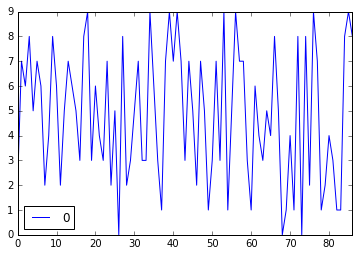

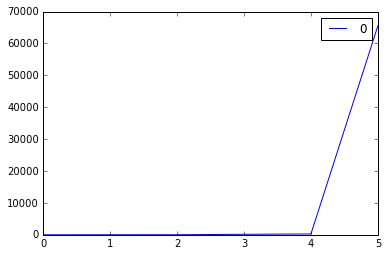

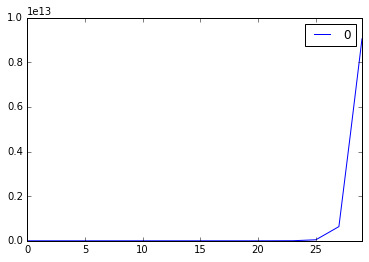

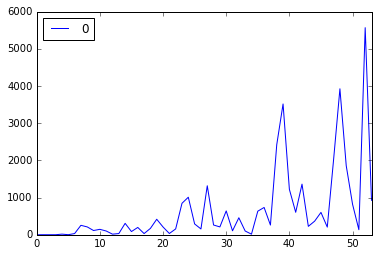

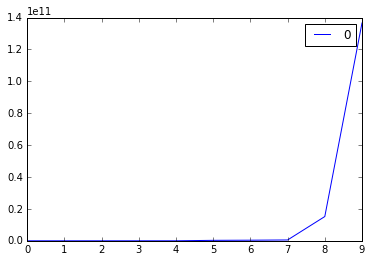

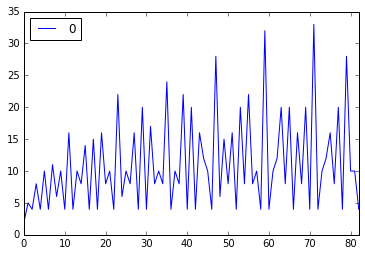

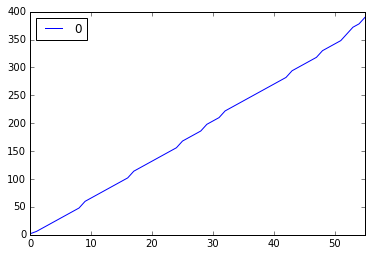

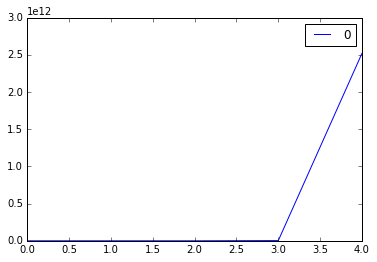

In [678]:
n, N = 2500,2510
for k, x in enumerate(seqs.values()):
    try:
        if (k > n and k < N):
            pd.DataFrame(x).astype(int).plot()
        elif k > N:
            break
    except:
        pass